# setup

In [1]:
%load_ext autoreload
%autoreload 2
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [2]:
from teren import dir_act_utils as dau, metric
from teren import utils as tu
from teren import direction, experiment_context
from transformer_lens import HookedTransformer
from teren.typing import *

device = tu.get_device_str()
print(f"{device=}")

device='cuda'


In [3]:
LAYER = 11
SEQ_LEN = 4
INFERENCE_TOKENS = 12_800
SEED = 0
tu.setup_determinism(SEED)
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")

N_PROMPTS = INFERENCE_BATCH_SIZE


input_ids = dau.get_input_ids(chunk=0, seq_len=SEQ_LEN)[:N_PROMPTS]
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

INFERENCE_BATCH_SIZE=3200
Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
exctx = experiment_context.ExperimentContext(
    model=model,
    layer=LAYER,
    input_ids=input_ids,
    acts_q_range=(0.01, 0.95),
    n_act=15,
    batch_size=INFERENCE_BATCH_SIZE,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
dirs = []
i = 0
while True:
    dir = torch.randn(model.cfg.d_model)
    dir /= dir.norm()
    dir = direction.Direction(dir, exctx)
    dirs.append(dir)
    dir.process_metric_mm(metric.jsd_metric)
    n_above_thresh = dir.res_by_metric[metric.jsd_metric].mm_sel.shape[0]
    dir.process_metric_cvx(metric.jsd_metric)
    print(f"{i=}, act range: {dir.act_min:.3f}, {dir.act_max:.3f}, {n_above_thresh=}")
    i += 1

i=0, act range: 0.027, 6.310, n_above_thresh=0
i=1, act range: 0.092, 2.240, n_above_thresh=0
i=2, act range: 0.083, 26.304, n_above_thresh=5772
i=3, act range: 0.049, 6.896, n_above_thresh=4
i=4, act range: 0.019, 3.277, n_above_thresh=0
i=5, act range: 0.591, 13.284, n_above_thresh=182


In [6]:
dir.process_metric_mm(metric.jsd_metric)
dir.res_by_metric[metric.jsd_metric].mm_sel.shape

torch.Size([1, 3])

In [12]:
matmet = dir.process_metric_cvx(metric.jsd_metric)

In [13]:
cvx_score, cvx_act = (
    dir.res_by_metric[metric.jsd_metric].cvx_score,
    dir.res_by_metric[metric.jsd_metric].cvx_act,
)
print(cvx_score.max())
print(cvx_score.shape)

tensor(0.8075)
torch.Size([12037])


In [14]:
max_lines = torch.gather(
    matmet,
    index=cvx_act.unsqueeze(0).unsqueeze(0).expand(-1, 10, -1),
    dim=0,
).squeeze()
max_lines.shape

torch.Size([10, 12037])

In [15]:
sorted_i = torch.argsort(cvx_score, descending=True)[:50:5]

In [16]:
lines = max_lines[:, sorted_i]
lines.shape

torch.Size([10, 10])

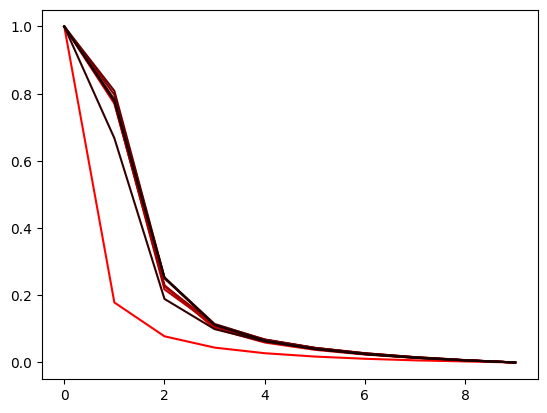

In [17]:
import matplotlib.pyplot as plt

for i, line in enumerate(lines.T):
    plt.plot(line / line.max(), color=(1 - i / 10, 0, 0))